# Coding our fist language model - very simple and useless :-)

# Simple markov chain to generate text

## What we do:
- create a statem machine where the state at step k is a particular word
- based on the state predict the next word

$$
s_{k + 1} = P s_{k}
$$
P is a transition matrix and s(k) gives us the current state (word)

# Markov Chain

In [394]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns


class MarkovChain:
    def __init__(self, text):
        self.text = text.lower().split()
        self.word_counts = {}  # Stores counts of words and their following words

    def build_counts(self):
        """Builds 1-gram model"""
        for i in range(len(self.text) - 2):
            # 1-gram model
            word = self.text[i]
            next_word = self.text[i + 1]
            if word not in self.word_counts:
                self.word_counts[word] = {}
            if next_word not in self.word_counts[word]:
                self.word_counts[word][next_word] = 0
            self.word_counts[word][next_word] += 1


    def predict_next_word_1gram(self, word):
        if word not in self.word_counts:
            return None  # 
        next_words = self.word_counts[word].keys()
        total_count = sum(self.word_counts[word].values())
        probs = [self.word_counts[word][w] / total_count for w in next_words]
        return random.choices(list(next_words), weights=probs)[0]


    def generate_text(self, starting_word, num_words, use_2gram=False):
        text = [starting_word]
        prev_word = starting_word  # For the 2-gram model
    
        for _ in range(num_words):
            
            next_word = self.predict_next_word_1gram(text[-1])
        
            if next_word and isinstance(next_word, str):  # Ensure it's a string
                text.append(next_word)
                prev_word = next_word  
            else:
                break 

        return " ".join(text)


# Some helper routines


def visualize_transition_matrix_as_graph(word_counts):
    # Create a directed graph from word_counts
    G = nx.DiGraph()

    # Add edges with probabilities as weights
    for word, next_words in word_counts.items():
        total_transitions = sum(next_words.values())
        for next_word, count in next_words.items():
            probability = count / total_transitions
            G.add_edge(word, next_word, weight=probability)

    # Draw the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=800,alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}, label_pos=0.5,font_size=6)
    plt.title("Markov Chain as a Network Graph")
    plt.axis('off')
    plt.show()



def visualize_transition_matrix(word_counts):
    # Create an empty DataFrame
    matrix_data = {}  
    all_words = set()

    # Collect words and prepare data
    for word, next_word_dict in word_counts.items():
        all_words.add(word)
        for next_word, count in next_word_dict.items():
            all_words.add(next_word)
            matrix_data.setdefault(word, {})[next_word] = count

    # Convert to DataFrame    
    df = pd.DataFrame(matrix_data, index=sorted(all_words), columns=sorted(all_words))

    # Normalize to probabilities
    df = df.div(df.sum(axis=1), axis=0) 
    df.fillna(0, inplace=True)  # Replace NaNs with probabilities of 0

    # Create Heatmap
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed 
    sns.heatmap(df, cmap="viridis")
    plt.xlabel("Next Word")
    plt.ylabel("Current Word")
    plt.title("Markov Chain Transition Matrix (Probabilities)")
    plt.show()


In [132]:
# Simple short text

text_long= " Moon whispers to moon dreams weave through dreams \
Stars mirror stars in the nights embrace \
Hearts echo hearts in loves silent streams \
Light follows light tracing times soft trace  \
Dreams follows dream tracing hidden secrets"

text_short= "Moon whispers to moon dreams weave through dreams. \
Stars mirror stars in the nights embrace"

model = MarkovChain(text_short) 
model.build_counts()


print("---Generated text---: \n", model.generate_text("to", 20)) 

---Generated text---: 
 to moon whispers to moon dreams weave through dreams. stars in the nights


In [106]:
model.word_counts

{'moon': {'whispers': 1, 'dreams': 1},
 'whispers': {'to': 1},
 'to': {'moon': 1},
 'dreams': {'weave': 1, 'stars': 1},
 'weave': {'through': 1},
 'through': {'dreams': 1},
 'stars': {'mirror': 1, 'in': 1},
 'mirror': {'stars': 1},
 'in': {'the': 1},
 'the': {'nights': 1}}

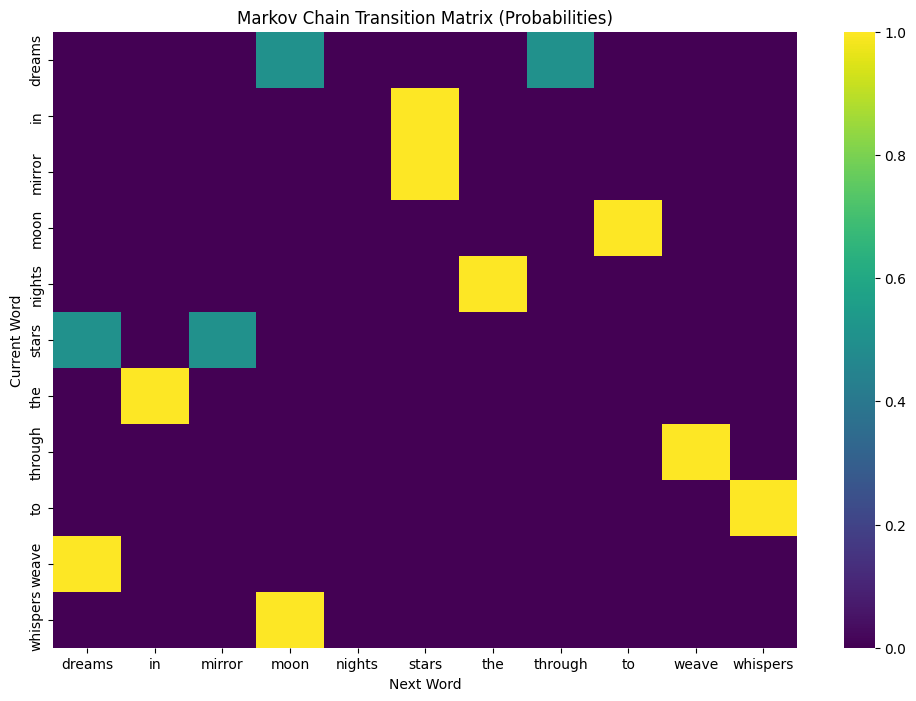

In [107]:


# Example Usage:
visualize_transition_matrix(model.word_counts) 


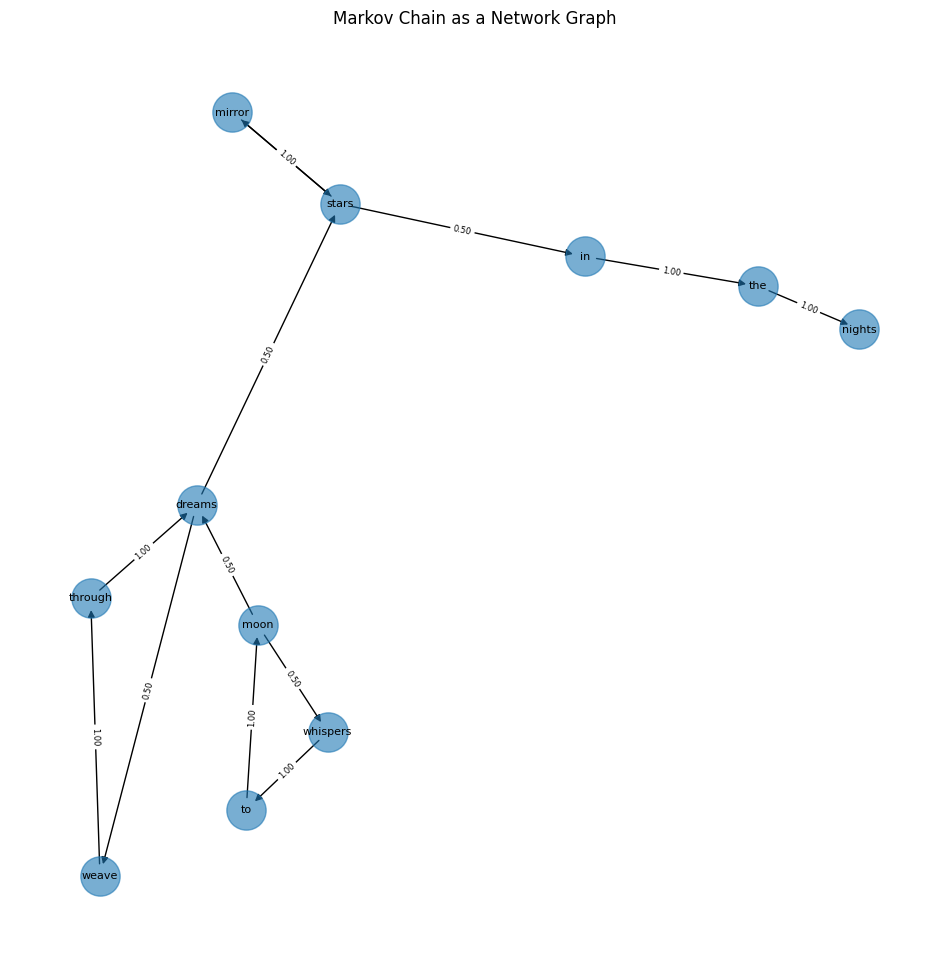

In [115]:

visualize_transition_matrix_as_graph(model.word_counts)


# for the brave ones:
- try to make it work with a 2-gram approach


# Simple RNN (many to one) *this needs a bit more knowledge in python and math

## Core Concepts

Simple RNN Cell: This code implements a fundamental RNN cell with a single hidden layer using the sigmoid activation function. Unlike more complex cells (LSTM, GRU), it doesn't have specialized gates to control information flow.
Backpropagation through Time (BPTT): BPTT is how RNNs learn through temporal sequences. This implementation uses a truncated version, looking back bptt_truncate timesteps.
Gradient Clipping: This technique addresses the issue of exploding gradients (common in RNNs) by limiting the maximum and minimum values gradients can take.


## 1. Functions:

sigmoid(x): The standard sigmoid function, used as the activation function within the RNN cell. It squashes values between 0 and 1.
### calculate_loss(X, Y, U, V, W):
Calculates the mean squared error between predicted values and true values (Y).
Acts as a starting point for training; the loss guides the weight updates.
### calc_layers(x, U, V, W, prev_activation):
Performs the forward pass calculations for a single sequence (x).
Stores the activation at each timestep and intermediate results (mulu, mulw, mulv).
### backprop(x, U, V, W, dmulv, mulu, mulw, layers):
Core of the BPTT implementation.
Calculates gradients (dU, dV, dW) for the weight matrices.
Employs gradient clipping to prevent instability during training.

## 2. Hyperparameters:

### learning_rate: 
Controls how much weights are adjusted during each update step.
### seq_len: 
Length of the input sequence fed into the RNN at a time.
### max_epochs: 
Number of training iterations.
### hidden_dim: 
The size of the RNN's hidden layer, determining its representational capacity.
### output_dim: 
Dimensionality of the output (here we expect a single value prediction).
### bptt_truncate: 
How far back in time to propagate gradients.

## 3. Training (train() Function)

### Initialization: 
Weight matrices U (input-to-hidden), V (hidden-to-output), and W (hidden-to-hidden) are likely randomly initialized.
### Epoch Loop: 
Iterates through the training dataset for the specified number of epochs.
### Forward Pass (calc_layers()):
Calculates outputs for a given sequence, storing necessary values for backpropagation.
### Backpropagation (backprop()): 
Computes gradients of the weights based on the error.
### Weight Updates: 
Adjusts U, V, and W using the calculated gradients and the learning rate.
### Validation: 
Calculates the loss on a separate validation set to monitor for overfitting.


## Formal description

The formulas for \\(h_t\\) (the hidden state at time \\(t\\\)) and \\(y_t\\\) (the output at time \\(t\\)) in the context of a many-to-one RNN architecture, as described in your code, are as follows:

### Hidden State \\(h_t\\)

The hidden state \\\(h_t\\) at time \\(t\\) is computed using the current input \\(x_t\\), the previous hidden state \\(h_{t-1}\\), and the weight matrices \\(U\\) (for input to hidden) and \\(W\\) (for hidden to hidden). The formula incorporates a sigmoid activation function (\\(\sigma\\)) to introduce non-linearity:

\\[ h_t = \sigma(U \cdot x_t + W \cdot h_{t-1}) \\]

where:
- \\(\sigma(x) = \frac{1}{1 + e^{-x}}\\) is the sigmoid activation function.
- \\(U\\) is the weight matrix for inputs to the hidden layer.
- \\(W\\) is the weight matrix for the previous hidden state to the current hidden state.
- \\(x_t\\) is the input vector at time \\(t\\).
- \\(h_{t-1}\\) is the hidden state vector at time \\(t-1\\).

### Output \\(y_t\\)

The output \\(y_t\\) in a many-to-one RNN setup is typically computed using the hidden state of the last timestep in the sequence (\\(h_T\\), where \\(T\\) is the length of the input sequence). This is then transformed using the weight matrix \\(V\\) (for hidden to output) and possibly passed through another activation function. Since your code directly uses the hidden state to calculate the output without specifying an additional activation function for the output layer, the formula for \\(y_t\\) (assuming \\(y_t\\) is the output after processing the entire sequence) is:

\\[ y_t = V \cdot h_T \\]

where:
- \\(V\\) is the weight matrix for the hidden layer to the output layer.
- \\(h_T\\) is the final hidden state after processing the entire input sequence.

It's important to note that in a many-to-one RNN, \\(y_t\\) is produced after the last timestep, relying on the accumulated information in \\(h_T\\), making the RNN suitable for tasks where the entire sequence informs a singular output (e.g., sentiment analysis or timeseries data).

In [390]:
import math
import numpy as np
import sklearn

# create vanilla RNN architecture many-to-one version 

learning_rate = 0.0001
seq_len = 50
max_epochs = 30

output_dim = 1
bptt_truncate = 5 # 
min_clip_val = -10
max_clip_val = 10

def sigmoid(x):
    return 1/(1+np.exp(-x))

def calculate_loss(X, Y, U, V, W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_activation = np.zeros((hidden_dim, 1)) # value of previous activation
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # forward pass, done for each step in the sequence
            new_input[timestep] = x[timestep] # define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_activation)
            _sum = mulu + mulw
            activation = sigmoid(_sum)
            mulv = np.dot(V, activation)
            prev_activation = activation
        # calculate and add loss per record
        loss_per_record = float((y - mulv)**2/2)
        loss += loss_per_record
    # calculate loss after first Y pass
    return loss, activation

# takes x values and the weights matrices
# returns layer dictionary, final weights (mulu, mulw, mulv)
def calc_layers(x, U, V, W, prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_activation)
        _sum = mulw + mulu
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        layers.append({'activation': activation, 'prev_activation': prev_activation})
        prev_activation = activation

    return layers, mulu, mulw, mulv

def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
    
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)
    
    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum * np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)
    
    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)
        
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
            
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
            
            dU_t += dU_i
            dW_t += dW_i
            
        dU += dU_t
        dV += dV_t
        dW += dW_t
        
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
        
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
        
    return dU, dV, dW

# training
def train(U, V, W, X, Y, X_validation, Y_validation):
    for epoch in range(max_epochs):
        # calculate initial loss, ie what the output is given a random set of weights
        loss, prev_activation = calculate_loss(X, Y, U, V, W)

        # check validation loss
        val_loss, _ = calculate_loss(X_validation, Y_validation, U, V, W)
        
        print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {val_loss}')

        # train model/forward pass
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim, 1))
            
            layers, mulu, mulw, mulv = calc_layers(x, U, V, W, prev_activation)
                
            # difference of the prediction
            dmulv = mulv - y
            dU, dV, dW = backprop(x, U, V, W, dmulv, mulu, mulw, layers)
            
            # update weights
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
            
    return U, V, W

In [391]:
sin_wave = np.array([math.sin(x) for x in range(200)])
# training data
X = []
Y = []
num_records = len(sin_wave) - seq_len 
 
# X entries are 50 data points
# Y entries are the 51st data point
for i in range(num_records-50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
 
X = np.expand_dims(np.array(X), axis=2) # 100 x 50 x 1
Y = np.expand_dims(np.array(Y), axis=1) # 100 x 1
 
# validation data
X_validation = []
Y_validation = []
for i in range(num_records-seq_len, num_records):
    X_validation.append(sin_wave[i:i+seq_len])
    Y_validation.append(sin_wave[i+seq_len])
 
X_validation = np.expand_dims(np.array(X_validation), axis=2)
Y_validation = np.expand_dims(np.array(Y_validation), axis=1)



In [392]:

hidden_dim = 50
np.random.seed(12161)
U = np.random.uniform(0, 1, (hidden_dim, seq_len)) # weights from input to hidden layer
V = np.random.uniform(0, 1, (output_dim, hidden_dim)) # weights from hidden to output layer
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim)) # recurrent weights for layer (RNN weigts)

U, V, W = train(U, V, W, X, Y, X_validation, Y_validation)

/var/folders/h6/rnpqq8d104s8k6rqjgnmrf840000gn/T/ipykernel_33897/991523936.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  loss_per_record = float((y - mulv)**2/2)


Epoch: 1, Loss: 34790.775768909254, Validation Loss: 17394.331091013843
Epoch: 2, Loss: 22856.34349496368, Validation Loss: 11427.307840806776
Epoch: 3, Loss: 13421.865605834153, Validation Loss: 6710.261763002017
Epoch: 4, Loss: 6484.686845442876, Validation Loss: 3241.8641989358716
Epoch: 5, Loss: 1986.4762699751402, Validation Loss: 992.9469909417008
Epoch: 6, Loss: 81.87136583669202, Validation Loss: 40.81123673379584
Epoch: 7, Loss: 28.02735385559695, Validation Loss: 13.960034105114158
Epoch: 8, Loss: 28.09322870561672, Validation Loss: 13.996833021068392
Epoch: 9, Loss: 28.045394752876966, Validation Loss: 13.974929736786992
Epoch: 10, Loss: 28.10516930198558, Validation Loss: 14.004900303355287
Epoch: 11, Loss: 28.207296907757176, Validation Loss: 14.05508948933214
Epoch: 12, Loss: 28.12078667120989, Validation Loss: 14.013136094651967
Epoch: 13, Loss: 28.136708639078172, Validation Loss: 14.020608008935776
Epoch: 14, Loss: 28.12377642713072, Validation Loss: 14.014031369222094

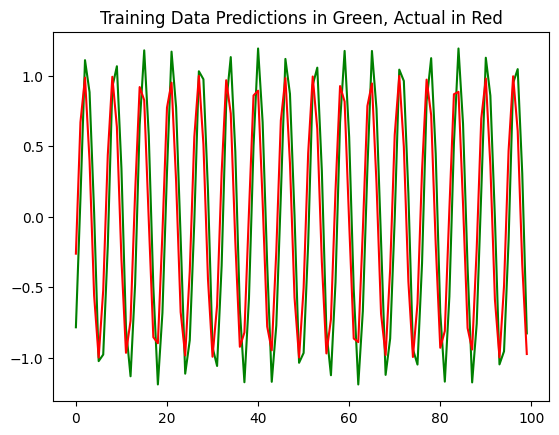

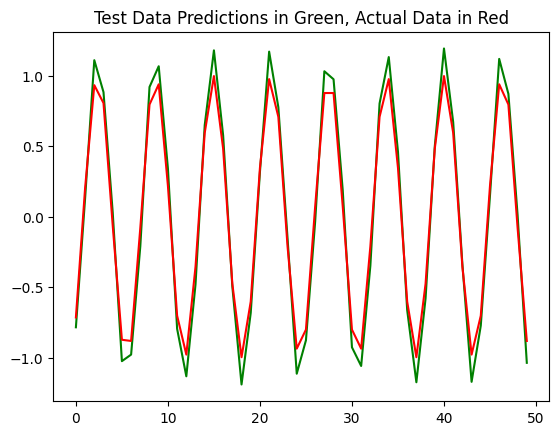

In [393]:
# predictions on the training set
predictions = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    predictions.append(mulv)
 
predictions = np.array(predictions)
 
plt.plot(predictions[:, 0,0], 'g')
plt.plot(Y[:, 0], 'r')
plt.title("Training Data Predictions in Green, Actual in Red")
plt.show()



# predictions on the validation set
val_predictions = []
for i in range(Y_validation.shape[0]):
    x, y = X[i], Y[i]
    prev_activation = np.zeros((hidden_dim,1))
    # forward pass
    for timestep in range(seq_len):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_activation)
        _sum = mulu + mulw
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        prev_activation = activation
    val_predictions.append(mulv)
 
val_predictions = np.array(val_predictions)
 
plt.plot(val_predictions[:, 0,0], 'g')
plt.plot(Y_validation[:, 0], 'r')
plt.title("Test Data Predictions in Green, Actual Data in Red")
plt.show()

# Transformers - its components

## Tokenization

In [253]:
import tiktoken

def tokenize_text(text, encoding_name="cl100k_base"):
    """Tokenizes a piece of text using OpenAI's tiktoken library.

    Args:
        text (str): The text to be tokenized.
        encoding_name (str, optional): The name of the OpenAI encoding to use. 
                                       Defaults to "cl100k_base".

    Returns:
        list: A list of tokens.
    """

    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)

    return tokens

# Example Usage
text_to_tokenize = "Natural language processing is fascinating!"
tokens = tokenize_text(text_to_tokenize)
print(tokens) 


[55381, 4221, 8863, 374, 27387, 0]


## Embedding

### Train word2Vec model - embeddings

In [320]:
from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# Path to the text8 dataset (you may need to download it if not already available)
text8_path = '/Users/marcel/HSLU/Lecture_Notes/data/text8'  

# Load the text8 corpus
text8_corpus = Text8Corpus(text8_path)

# Train a Word2Vec model on the text8 dataset
model = Word2Vec(sentences=text8_corpus, vector_size=100, window=5, min_count=1, workers=4)






In [321]:
# Example: Get an embedding for a word
word_embedding = model.wv['language']

# Find most similar words
similar_words = model.wv.most_similar('language', topn=5)
print("Most similar words to 'computer':", similar_words)

Most similar words to 'computer': [('languages', 0.8432613015174866), ('vocabulary', 0.794221043586731), ('esperanto', 0.7663034796714783), ('dialect', 0.7524361610412598), ('grammar', 0.7458307147026062)]


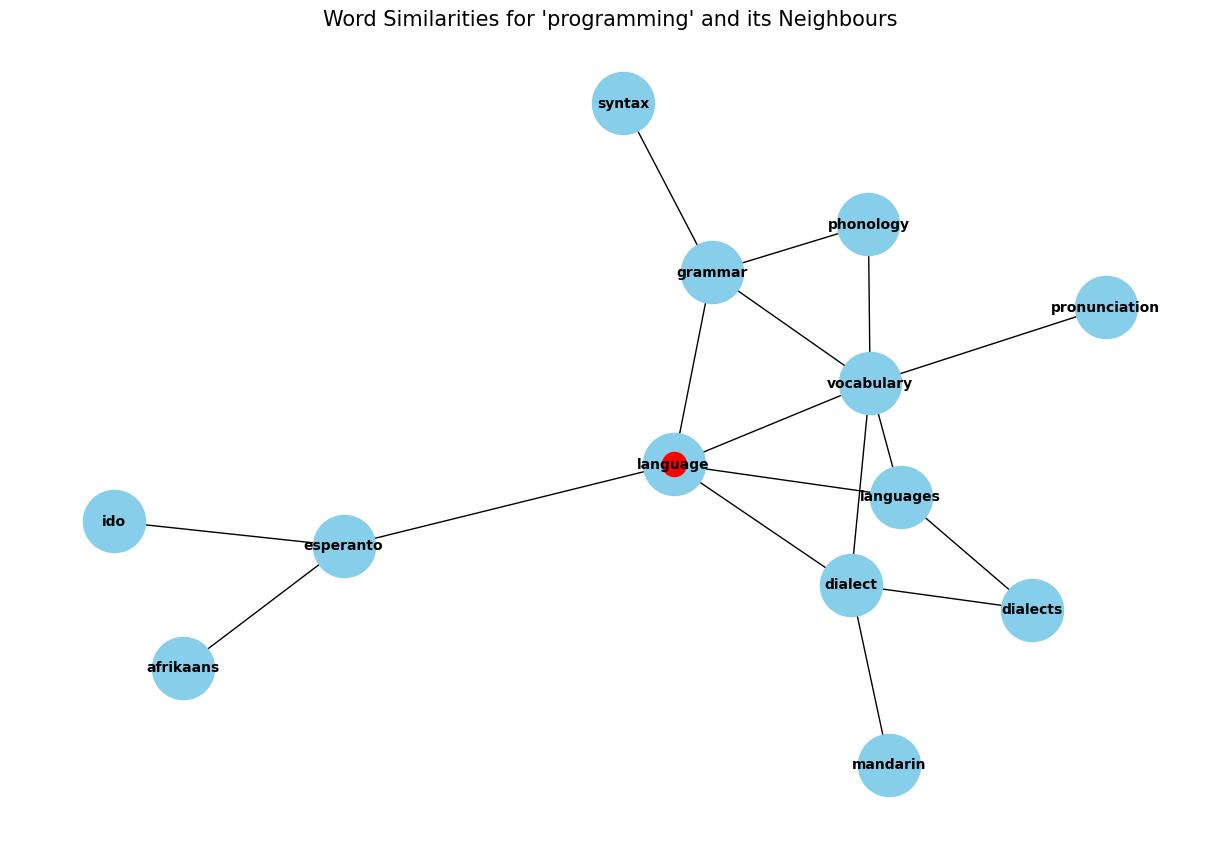

In [323]:


# Initialize a new graph
G = nx.Graph()

# Add the initial node
initial_word = 'language'
G.add_node(initial_word)

# Find 5 most similar words to the initial word
top_similar_words = model.wv.most_similar(initial_word, topn=5)

# Add nodes and edges for the 5 most similar words
for word, _ in top_similar_words:
    G.add_node(word)
    G.add_edge(initial_word, word)
    
    # For each of the 5 similar words, find another 3 similar words
    next_top_similar_words = model.wv.most_similar(word, topn=3)
    
    # Add nodes and edges for these 3 similar words
    for next_word, _ in next_top_similar_words:
        G.add_node(next_word)
        G.add_edge(word, next_word)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout

nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='k', node_size=2000, font_size=10, font_weight='bold')
nx.draw_networkx_nodes(G,pos=pos,nodelist=[initial_word],node_color='red')
plt.title("Word Similarities for 'programming' and its Neighbours", size=15)
plt.show()


### Train your own embedding

### Simple explanation how embedding is 'calculated'

Word2Vec is a popular technique in natural language processing (NLP) for learning word embeddings. It transforms words into vectors in such a way that words with similar meanings have similar vector representations. Word2Vec can utilize one of two architectures: Continuous Bag of Words (CBOW) or Skip-Gram. Here's a step-by-step explanation of what happens behind the scenes for each architecture:

### Continuous Bag of Words (CBOW)

1. **Objective**: Predict a target word from a given context. For example, given the context words ["the", "cat", "on", "the"], the model might predict the target word "sat".

2. **Input and Output**: The input is the context, which consists of several words surrounding the target word. The output is the target word itself. In practice, both input and output are one-hot encoded vectors of size equal to the vocabulary.

3. **Process**:
    - **a. Context Aggregation**: The context words are first embedded into a continuous space (initially with random values). The model then aggregates these context embeddings, usually by averaging, to form a single context vector.
    - **b. Hidden Layer**: The aggregated context vector is then passed through a hidden layer (a linear transformation without activation).
    - **c. Output Layer**: The hidden layer's output is fed into an output layer, which predicts the target word. This layer typically uses a softmax function to generate probabilities for every word in the vocabulary being the target word.
    - **d. Training**: The model is trained by adjusting the embeddings to minimize the difference between the predicted and actual target word. This is usually done using backpropagation and an optimization algorithm like stochastic gradient descent.

4. **Result**: After training, the weights of the model (the word embeddings) are adjusted so that words appearing in similar contexts have similar embeddings.

### Skip-Gram

1. **Objective**: Predict context words given a target word. It's the inverse of CBOW. For example, given the target word "sat", the model might predict the context words ["the", "cat", "on", "the"].

2. **Input and Output**: The input is a single target word, and the output is the context words surrounding this target word. Like CBOW, both are represented as one-hot encoded vectors.

3. **Process**:
    - **a. Target Word Embedding**: The target word is first embedded into a continuous space.
    - **b. Hidden Layer**: The target word embedding is passed through a hidden layer (again, a linear transformation without activation).
    - **c. Output Layer**: For each context position (e.g., the word immediately before, two words before, the word immediately after, etc.), the model uses the hidden layer's output to predict the context word at that position. Like CBOW, this typically involves a softmax function.
    - **d. Training**: The model is trained by adjusting the embeddings to maximize the probability of the actual context words given the target word.

4. **Result**: The training process results in word embeddings where words with similar contexts are located close to one another in the embedding space.

### Key Differences Between CBOW and Skip-Gram

- **Efficiency**: CBOW tends to be faster and has slightly better accuracy for frequent words, while Skip-Gram is slower but better with rare words and phrases.
- **Quality of Embeddings**: Skip-Gram tends to produce more detailed embeddings than CBOW and is better at capturing relationships between more distant words.

In both architectures, the essence of Word2Vec is to leverage the context in which words appear within large text corpora to learn meaningful representations, capturing syntactic and semantic word relationships in a dense, low-dimensional space.

## Self attention - simplified a looooot

### Example to show off the main idea of self attention

In [324]:
# Define arbitrary vectors for each word in our sentence.
# In practice, these would be learned from data.

words = ["we", "are", "made", "of", "star", "dust"]

# Assume these are pre-computed embeddings for simplicity
Q = {
    "we": [1, 0, 0],
    "are": [0, 1, 0],
    "made": [0, 0, 1],
    "of": [1, 1, 0],
    "star": [1, 0, 1],
    "dust": [0, 1, 1]
}

K = Q  # In this simple example, let's use the same values for keys
V = Q  # and values for simplicity.



In [326]:


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# Simplified attention calculation without scaling
attention_scores = {word: np.zeros(len(words)) for word in words}

for word in words:
    q = np.array(Q[word])
    for target_word in words:
        k = np.array(K[target_word])
        # Calculate dot product
        attention_scores[word][words.index(target_word)] = np.dot(q, k)

# Apply softmax to normalize scores
for word, scores in attention_scores.items():
    attention_scores[word] = softmax(scores)

print("Attention Scores (Softmax Applied):")
for word, scores in attention_scores.items():
    print(f"{word}: {scores}")


Attention Scores (Softmax Applied):
we: [0.24368619 0.08964714 0.08964714 0.24368619 0.24368619 0.08964714]
are: [0.08964714 0.24368619 0.08964714 0.24368619 0.08964714 0.24368619]
made: [0.08964714 0.08964714 0.24368619 0.08964714 0.24368619 0.24368619]
of: [0.14112013 0.14112013 0.05191519 0.38360429 0.14112013 0.14112013]
star: [0.14112013 0.05191519 0.14112013 0.14112013 0.38360429 0.14112013]
dust: [0.05191519 0.14112013 0.14112013 0.14112013 0.14112013 0.38360429]


## Feed Forward Neural Network

In [383]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

class NeuralNetwork:
  def __init__(self, input_size, hidden_size, output_size):
    self.W1 = np.random.randn(input_size, hidden_size) 
    self.b1 = np.zeros(hidden_size)
    self.W2 = np.random.randn(hidden_size, output_size)
    self.b2 = np.zeros(output_size)

  def forward(self, X):
    self.z1 = np.dot(X, self.W1) + self.b1
    self.a1 = sigmoid(self.z1)  # Hidden layer activation
    self.z2 = np.dot(self.a1, self.W2) + self.b2
    self.a2 = sigmoid(self.z2)  # Output layer 
    return self.a2

  def backward(self, X, y, output):
    self.output_error = y - output 
    self.output_delta = self.output_error * sigmoid_derivative(self.z2)

    self.hidden_error = np.dot(self.output_delta, self.W2.T)
    self.hidden_delta = self.hidden_error * sigmoid_derivative(self.z1)

    self.W2 += np.dot(self.a1.T, self.output_delta) * learning_rate 
    self.b2 += self.output_delta.sum(axis=0) * learning_rate
    self.W1 += np.dot(X.T, self.hidden_delta) * learning_rate
    self.b1 += self.hidden_delta.sum(axis=0) * learning_rate 

# Sample usage 
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])  

nn = NeuralNetwork(2, 5, 1)  # 2 inputs, 3 hidden units, 1 output

learning_rate = 0.01

for i in range(100000): 
  output = nn.forward(X)
  nn.backward(X, y, output)



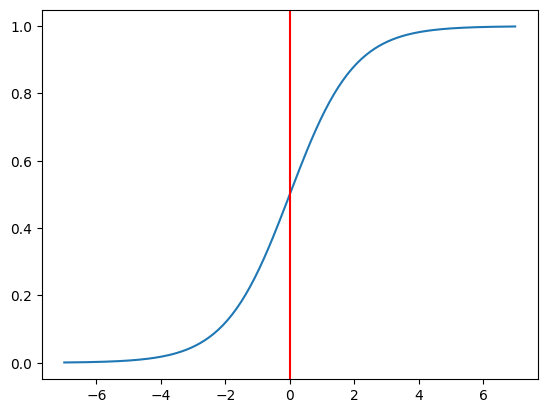

In [378]:
x = np.linspace(-7,7,200)
y = sigmoid(x)
plt.plot(x,y)
plt.axvline(x=0., color='r', linestyle='-')



In [388]:
# New test data point
new_input = np.array([1, 0]) 

# Make a prediction
output = nn.forward(new_input)
print("Predicted output:", output) 

Predicted output: [0.96173145]


### for the brave ones :-)


#### Weights:
- W1: Weights between the input and hidden layer
- W2: Weights between the hidden and output layer
#### Biases:
- b1: Biases for the hidden layer
- b2: Biases for the output layer
#### Activations:
- a1: Activations of the hidden layer
- a2: Activation of the output layer (also the final prediction)
#### Pre-activation outputs:
- z1: Weighted input to the hidden layer (before applying the activation)
- z2: Weighted input to the output layer (before applying the activation)
#### Loss: 

**We'll assume a squared error loss: L = (1/2)(y - a2)^2**

superscript T: Indicates matrix transpose

Backpropagation Formulas

**Output Error:**

δ2 = (y - a2) * σ'(z2)
Hidden Error:

δ1 = W2^T * δ2 * σ'(z1)

**Weight Gradients:**

∂L/∂W2 = a1^T * δ2
∂L/∂W1 = X^T * δ1

**Bias Gradients:**

∂L/∂b2 = sum(δ2, axis=0)
∂L/∂b1 = sum(δ1, axis=0)

#### Take away message
σ'(x): Represents the derivative of the sigmoid activation function: σ(x)(1 - σ(x))
Chain Rule: Backpropagation is essentially the application of the chain rule of calculus to compute gradients throughout the network.
Matrix Shapes: It's crucial to keep track of the shapes of matrices and vectors during these calculations as they must align for correct matrix multiplication.